In [2]:
import os
import sys
from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
from torch.utils import data as D
# mixed precision
from apex import amp

# Local imports
sys.path.append('../src')
import dataset
import trainer
import models
import utils
import preprocessing
import mix

# Transformers
import transformers
from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

# Setup device
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Seed 
utils.seed_everything()

print('use', device)

use cuda


## Datasets

In [3]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [4]:
debug = False
use_features = True
feature_slice = slice(0,3072)

In [5]:
%%time
if debug:
    valid = dataset.Dataset('../input/validatio_debug_32.npz')
else:
    valid = dataset.Dataset('../input/validation.npz', use_features=use_features, feature_slice=feature_slice)
#     valid = dataset.Dataset('../input/jigsaw_miltilingual_valid_translated.npz', use_features=use_features)
valid.x.shape, valid.y.shape

CPU times: user 0 ns, sys: 146 ms, total: 146 ms
Wall time: 1.96 s


((8000, 3072), (8000,))

In [6]:
%%time
if debug:
    test = dataset.Dataset('../input/test_debug_32.npz')
else:
    test = dataset.Dataset('../input/test.npz', use_features=use_features, feature_slice=feature_slice)
test.x.shape, test.y.shape

CPU times: user 0 ns, sys: 949 ms, total: 949 ms
Wall time: 6.98 s


((63812, 3072), (63812,))

In [7]:
%%time
if debug:
    train = dataset.Dataset('../input/jigsaw-toxic-comment-trai_debug_32.npz')
else:
    train = dataset.Dataset('../input/jigsaw-toxic-comment-train.npz', use_features=use_features, feature_slice=feature_slice)
train.x.shape, train.y.shape

CPU times: user 500 ms, sys: 2.38 s, total: 2.88 s
Wall time: 17.7 s


((223549, 3072), (223549,))

In [8]:
np.save('../input/jigsaw_roberta_features/jigsaw-toxic-comment-train_y.npy', train.y)
np.save('../input/jigsaw_roberta_features/validation_y.npy', valid.y)
np.save('../input/jigsaw_roberta_features/test_y.npy', test.y)

In [121]:
%%time
if debug:
    train_aux = dataset.Dataset('../input/jigsaw-toxic-comment-trai_debug_32.npz')
else:
    train_aux = dataset.Dataset('../input/jigsaw-unintended-bias-train.npz', use_features=use_features)
train_aux.x.shape, train_aux.y.shape

CPU times: user 14 s, sys: 28.2 s, total: 42.2 s
Wall time: 1min 43s


((1902194, 3072), (1902194,))

In [9]:
def weighted_sampler(y):
    labels, counts = np.unique(y, return_counts=True)
    weights = counts[::-1] / counts.sum()
    weights = np.array([weights[i] for i in y])
    return torch.utils.data.sampler.WeightedRandomSampler(weights, int(counts.min() * 2))

In [11]:
sampler = weighted_sampler(train.y)

In [12]:
sampler.weights

tensor([0.0957, 0.0957, 0.0957,  ..., 0.0957, 0.9043, 0.0957],
       dtype=torch.float64)

In [310]:
train = torch.utils.data.ConcatDataset([train, valid])
train_y = np.concatenate([d.y for d in train.datasets])
sampler = weighted_sampler(train_y)
len(sampler)

45228

## Model

In [8]:
reload(models)
reload(mix)

<module 'mix' from '../src/mix.py'>

In [7]:
backbone_name = 'xlm-roberta-large'
# backbone = XLMRobertaModel(XLMRobertaConfig.from_pretrained(backbone_name))
backbone = XLMRobertaModel.from_pretrained(backbone_name, output_hidden_states=False, num_labels=1)

In [24]:
# to reload the module and not overload gpu
del model

In [25]:


# model = models.Model(backbone, mix=False, dropout=0.55)
# model = models.SimplePoolingHead(mix=True, dropout=0.5)
model = models.TransformersPoolingHead(mix=mix.Mixup(), dropout=0.5, relu=True)
# model = models.CustomPoolingHead(mix=mix.Cutmix(continuous=False), dropout=0.5)
# model = models.CustomPoolingHead(in_features=3072, mix=mix.Mixup(), dropout=0.5)
model

TransformersPoolingHead(
  (head): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=3072, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

## Feature extraction

In [8]:
reload(preprocessing)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'preprocessing' from '../src/preprocessing.py'>

In [9]:
preprocessing.extract_roberta_features_to_file('../input/validation.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:13<00:00,  4.02s/it]


In [145]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw_miltilingual_valid_translated.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:14<00:00,  4.03s/it]


In [10]:
preprocessing.extract_roberta_features_to_file('../input/test.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 499/499 [34:04<00:00,  4.10s/it]


In [9]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw_miltilingual_test_translated.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:13<00:00,  4.02s/it]


In [11]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw-toxic-comment-train.npz', backbone=backbone, device=device, batch_size=128)

feature extraction: 100%|##########| 1747/1747 [1:58:03<00:00,  4.05s/it]


In [113]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw-unintended-bias-train.npz', backbone=backbone, device=device, batch_size=128)

feature extraction:  21%|##        | 3065/14861 [3:26:57<13:17:12,  4.05s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

feature extraction: 100%|##########| 14861/14861 [16:47:01<00:00,  4.07s/it]  


## Data loaders

In [10]:
batch_size = 64
num_workers = 8

loader_train = D.DataLoader(train, 
                            sampler=train.weighted_sampler(), 
#                             sampler=sampler, 
#                             shuffle=True,
                            batch_size=batch_size, num_workers=num_workers)
loader_valid = D.DataLoader(valid, 
                            batch_size=batch_size, num_workers=num_workers)
loader_test = D.DataLoader(test, 
                           batch_size=batch_size, num_workers=num_workers)

In [11]:
len(loader_train), len(loader_valid), len(loader_test)

(669, 125, 998)

## Trainer

In [26]:
reload(trainer)

<module 'trainer' from '../src/trainer.py'>

In [27]:
# we may optimize only head (with encoder pretrained)
# optimizer = AdamW(model.head.parameters(), lr=1e-4)
optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 4, T_mult=2, eta_min=0, last_epoch=-1)
# criterion = trainer.FocalLoss(gamma=2)
# criterion = trainer.DenseCrossEntropy(label_smoothing=0.1)
# scheduler = get_linear_schedule_with_warmup(optimizer, 5, 5)

trnr = trainer.Trainer('transformer_relu_O1', model, 
                       loader_train, loader_valid, loader_test,
                       epochs=20,
                       monitor='val_loss',
                       optimizer=optimizer,
                       opt_level='O1',
#                        criterion=criterion,
#                        scheduler=scheduler,
                      )

Use automatic mixed precision at opt_level=O1
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


## Training

In [28]:
trnr.fit()

ep. 0000 (lr 1.00e-04): 100%|##########| 669/669 [00:15<00:00, 42.19it/s, loss=0.531, acc=0.754]
/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
valid: 100%|##########| 125/125 [00:00<00:00, 164.05it/s]


Epoch 0 complete. loss=0.4026, val_loss=0.3114, val_acc=0.8819, val_auc=0.8906
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 216.74it/s]


Epoch 1 complete. loss=0.3933, val_loss=0.3184, val_acc=0.8824, val_auc=0.8978
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 205.55it/s]


Epoch 2 complete. loss=0.5488, val_loss=0.3316, val_acc=0.8784, val_auc=0.8979
Saved model to ../checkpoints//transformer_relu_O1_last.pth


ep. 0003 (lr 9.46e-05):  17%|#6        | 112/669 [00:01<00:05, 105.64it/s, loss=0.448, acc=0.821]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


valid: 100%|##########| 125/125 [00:00<00:00, 230.58it/s]


Epoch 3 complete. loss=0.4267, val_loss=0.3181, val_acc=0.8845, val_auc=0.8971
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 210.56it/s]


Epoch 4 complete. loss=0.2934, val_loss=0.3233, val_acc=0.8828, val_auc=0.8998
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 174.47it/s]


Epoch 5 complete. loss=0.5332, val_loss=0.3163, val_acc=0.8849, val_auc=0.9016
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 193.40it/s]


Epoch 6 complete. loss=0.3650, val_loss=0.3057, val_acc=0.8844, val_auc=0.8985
Saved model to ../checkpoints//transformer_relu_O1.pth


valid: 100%|##########| 125/125 [00:00<00:00, 210.64it/s]


Epoch 7 complete. loss=0.4630, val_loss=0.3271, val_acc=0.8802, val_auc=0.8994
Saved model to ../checkpoints//transformer_relu_O1_last.pth


ep. 0008 (lr 6.55e-05):  20%|##        | 134/669 [00:01<00:04, 109.19it/s, loss=0.424, acc=0.839]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


valid: 100%|##########| 125/125 [00:00<00:00, 207.32it/s]


Epoch 8 complete. loss=0.4178, val_loss=0.3008, val_acc=0.8838, val_auc=0.8994
Saved model to ../checkpoints//transformer_relu_O1.pth


valid: 100%|##########| 125/125 [00:00<00:00, 194.78it/s]


Epoch 9 complete. loss=0.4986, val_loss=0.3459, val_acc=0.8704, val_auc=0.9033
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 160.97it/s]


Epoch 10 complete. loss=0.3423, val_loss=0.2882, val_acc=0.8838, val_auc=0.8979
Saved model to ../checkpoints//transformer_relu_O1.pth


ep. 0011 (lr 4.22e-05):  59%|#####9    | 398/669 [00:03<00:02, 106.71it/s, loss=0.423, acc=0.838]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


valid: 100%|##########| 125/125 [00:00<00:00, 176.58it/s]


Epoch 11 complete. loss=0.6821, val_loss=0.2924, val_acc=0.8852, val_auc=0.9004
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 197.92it/s]


Epoch 12 complete. loss=0.2772, val_loss=0.2974, val_acc=0.8855, val_auc=0.9004
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 182.55it/s]


Epoch 13 complete. loss=0.3834, val_loss=0.2884, val_acc=0.8849, val_auc=0.9014
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 154.45it/s]


Epoch 14 complete. loss=0.3487, val_loss=0.3045, val_acc=0.8866, val_auc=0.9010
Saved model to ../checkpoints//transformer_relu_O1_last.pth


ep. 0015 (lr 1.46e-05): 100%|#########9| 668/669 [00:06<00:00, 102.52it/s, loss=0.418, acc=0.843]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


valid: 100%|##########| 125/125 [00:00<00:00, 199.76it/s]


Epoch 15 complete. loss=0.4601, val_loss=0.2914, val_acc=0.8865, val_auc=0.9027
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 173.21it/s]


Epoch 16 complete. loss=0.4848, val_loss=0.3005, val_acc=0.8872, val_auc=0.9022
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 177.84it/s]


Epoch 17 complete. loss=0.4873, val_loss=0.2959, val_acc=0.8866, val_auc=0.9029
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 188.36it/s]


Epoch 18 complete. loss=0.3690, val_loss=0.2936, val_acc=0.8860, val_auc=0.9026
Saved model to ../checkpoints//transformer_relu_O1_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 173.35it/s]


Epoch 19 complete. loss=0.3388, val_loss=0.2946, val_acc=0.8862, val_auc=0.9026
Saved model to ../checkpoints//transformer_relu_O1_last.pth


## Prediction

In [21]:
trnr.load_checkpoint()

Load state in automatic mixed precision mode at opt_level=O1
Loaded model from ../checkpoints//custom_head_bn_bias=False_O1.pth
epoch 19, loss: 0.4936val_loss: 0.2795val_acc: 0.8756val_auc: 0.9041


In [22]:
pred, loss, acc, auc = trnr.validate()

valid: 100%|##########| 125/125 [00:00<00:00, 181.50it/s]


In [23]:
auc

0.904126406552101

In [191]:
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.special import softmax

In [294]:
smpred = softmax(pred / 1, 1)[:,1]
smpred[:5]

array([0.11696827, 0.08446362, 0.09727458, 0.03982643, 0.1031474 ],
      dtype=float32)

In [295]:

acc = accuracy_score(valid.y, np.round(smpred))
auc = roc_auc_score(valid.y, smpred)
print(f'all: acc {acc:.4f}, auc {auc:.4f}\n')

for lang in ['es', 'it', 'tr']:
    mask = valid.dataset['lang'] == lang
    acc = accuracy_score(valid.y[mask], np.round(smpred[mask]))
    auc = roc_auc_score(valid.y[mask], smpred[mask])
    print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')
    

all: acc 0.8832, auc 0.9042

es: acc 0.8704, auc 0.8793
it: acc 0.8508, auc 0.8632
tr: acc 0.9210, auc 0.9622


In [296]:
import seaborn as sns

In [300]:
from sklearn.calibration import calibration_curve

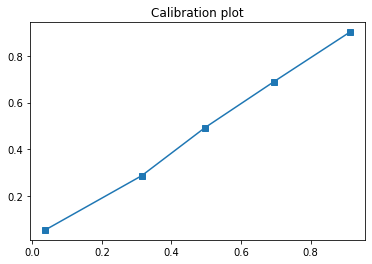

In [305]:
plt.plot(*calibration_curve(valid.y, smpred), 's-')
plt.title('Calibration plot')
plt.show()

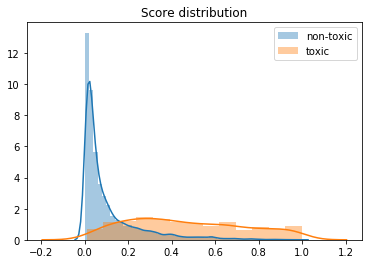

In [299]:
fig, ax = plt.subplots()

sns.distplot(smpred[valid.y == 0], ax=ax, label='non-toxic')
sns.distplot(smpred[valid.y == 1], ax=ax, label='toxic')
plt.legend()
plt.title('Score distribution')
plt.show()

In [240]:
for lang in ['es', 'it', 'tr']:
    mask = valid.dataset['lang'] == lang
    acc = accuracy_score(valid.y[mask], np.round(pred[mask]))
    auc = roc_auc_score(valid.y[mask], pred[mask])
    print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')

es: acc 0.8696, auc 0.8733
it: acc 0.8528, auc 0.8532
tr: acc 0.9167, auc 0.9672


In [19]:
pred, loss, acc = trnr.test()

test: 100%|##########| 31906/31906 [38:58<00:00, 13.65it/s]
